In [148]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [3]:
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=10000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation_func = self._unit_step_func
        self.weights = None
        self.bias = None
    
    def _unit_step_func(self, X):
        return np.where(X>0, 1, 0)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        labels = np.array([1 if i > 0 else 0 for i in y])
        
        for _ in range(self.n_iters):
            
            for idx, x_i in enumerate(X):
                
                # Input layer dot weights layer
                linear_output = np.dot(x_i, self.weights) + self.bias
                
                # Result of operation above activated into a binary output (model prediction)
                y_predicted = self._unit_step_func(linear_output)
                
                # Perceptron update rule
                update = (labels[idx]-y_predicted) * self.lr
                self.weights += update * x_i
                self_bias += update
                               
    def predict(self, X):
        linear_output = np.dot(self.weights, X) + self.bias
        y_predicted = self._unit_step_func(linear_output)
        return y_predicted

In [4]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [5]:
penguins = penguins.dropna()
penguins.species.value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [6]:
int_cols = penguins.iloc[:, 2:6]
int_cols.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [277]:
# Improvements on lines 62, 80, 110

class my_UMAP:
    def __init__(self, learning_rate=0.01, nearest_neighbors=15):
        self.lr = learning_rate
        self.nn = nearest_neighbors
        
    def _euclidean_dist_all(self, df_nums): # df_nums needs to be composed on only integer values
        all_dists = {} # dict with key as index of value 
        i = 0
        
        for p in int_cols.iloc[:].values:
            temp = np.array([])

            for pp in int_cols.iloc[:].values:
                dist = np.linalg.norm(p - pp)
                temp = np.append(temp, dist)

            all_dists[i] = temp
            i += 1
        
        return all_dists
    
    def graph_original_nns(self, dists, show_visuals, ngraphs):
        
        dists_dict = {}
        
        for key in dists:
            
            all_curr_dists = dists[key] # dists[key] is an array with the values for all distances from the point at index 'key'
                                            # (from original data) which preserves the original order of the data points
                                 
            min_inds = all_curr_dists.argsort()[:self.nn+1]
            min_inds = min_inds[min_inds != key] # stores the values of the indexes of the nearest neighbors
            
            # Create array with the distances of the point 'key' to its nearest neighbors
            curr_dists_nns = np.array([])
            for ind in min_inds:
                curr_dists_nns = np.append(curr_dists_nns, all_curr_dists[ind]) # values are already sorted
            
            # Plot graphs -- Optional
            if show_visuals == True and key <= (ngraphs-1):
            
                plt.plot(curr_dists_nns, np.zeros_like(curr_dists_nns), 'ko')
                plt.plot(0, 0, 'c*')
                plt.annotate('Origin point', (0, 0), xytext=(0, 2), arrowprops=dict(arrowstyle='<-', color='cyan', linewidth=2))
                plt.xlabel(f'Nearest {self.nn} Neighbors')
                plt.ylim(-0.5, 5)
                plt.show()

                print('Distances to nearest neighbors: ', curr_dists_nns)
            
            # Nested dictionary to store useful info about a data point
            dists_dict[key] = {}
            dists_dict[key]['nns_indexes'] = min_inds
            dists_dict[key]['dists_to_nns'] = curr_dists_nns
            dists_dict[key]['all_dists'] = all_curr_dists
        
        return dists_dict
            
    
    def graph_similarity_scores(self, dists_dict, show_visuals, ngraphs, theta=1): ################ TRAIN THETA
    
        i = 0
        
        for k, d in dists_dict.items():
            
            dists_nns_only = d['dists_to_nns']
            nneighbor = dists_nns_only[0]
            similarity_scores = np.array([])
            
            for dist in dists_nns_only:
                
                # Calculate similarity scores of nearest neighbors
                similarity_score = np.exp(-(dist-nneighbor)/theta)
                similarity_scores = np.append(similarity_scores, similarity_score)
            
            
            # Plot graphs -- Optional
            if show_visuals == True and i <= (ngraphs-1):  ######## FIX SMOOTHNESS OF LINE -- EXPONENTIAL INSTEAD OF QUADRATIC
                
                plt.plot(dists_nns_only, similarity_scores, 'ko')

            # ATTEMPT TO DRAW A LINE TO CONNECT POINTS -- LOOKING FOR EXPONENTIAL, NOT QUADRATIC KIND
    #             x_new = np.linspace(dists_nns_only[0], dists_nns_only[-1],500)
    #             f = interp1d(dists_nns_only, similarity_scores, kind='quadratic')
    #             y_smooth=f(x_new)
    #             plt.plot(x_new, y_smooth)

                plt.xlabel(f"Nearest {self.nn} Neighbors' SSs")
                plt.ylim(-0.5, 1.5)
                plt.show()
                
                print('Similarity Scores: ', similarity_scores)
                i += 1
            
            dists_dict[k]['similarity_scores'] = similarity_scores
        
        return dists_dict
        
        
    
    def fit(self, df_nums, show_visuals=False, ngraphs=5):
        
        # Step 1 - calculate distances between each pair of points -> euclidean distance -- DONE
        all_dists = self._euclidean_dist_all(df_nums)
        
        # Step 2 - make a graph for each point where the origin is that point and the other points are placed on the 
        #    x-axis in relation to their distance to the origin point -- DONE
        dists_dict = self.graph_original_nns(all_dists, show_visuals=show_visuals, ngraphs=ngraphs) ######## SEE WHERE *args, **kwargs CAN BE USED
        
        # Step 3 - decide on number of high dimensional neighbors (including the point itself, common value is 15) -- DONE
        
        # Step 4 - draw a curve based on the distances and nn parameter. The curve is drawn in such a way that the sum of 
        #    the y-coordinates that match up with the number of neighbors equals the log2(nns) -- INCOMPLETE
        dists_dict = self.graph_similarity_scores(dists_dict, show_visuals=show_visuals, ngraphs=ngraphs)
        print(dists_dict[0])
        
        # Step 5 - converge similarity scores between the same points into one --> symmetrical similarity score (SSS)
            # dists_dict -> first key represents the index of the origin point in the original data
                # inside that key we have -> 'nns_indexes' (in original data, ordered), 'dists_to_nns' (ordered),
                    # 'all_dists' (ordered based on original data), 'similarity_scores' (ordered)
        

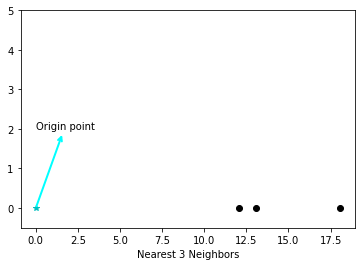

Distances to nearest neighbors:  [12.08511481 13.09236419 18.069311  ]


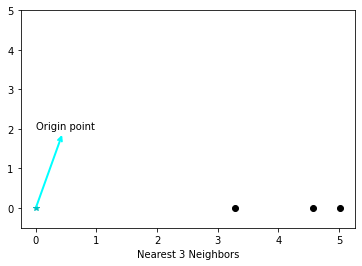

Distances to nearest neighbors:  [3.28633535 4.57055795 5.01996016]


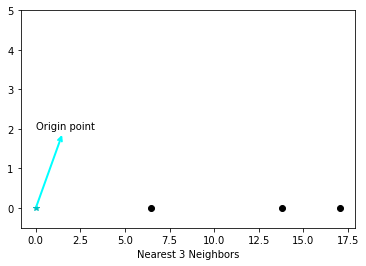

Distances to nearest neighbors:  [ 6.47842573 13.78150935 17.06839184]


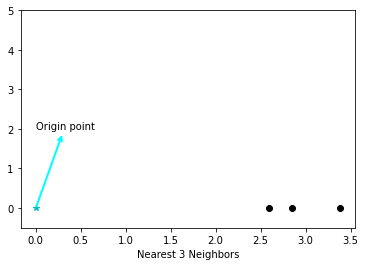

Distances to nearest neighbors:  [2.596151   2.84429253 3.38378486]


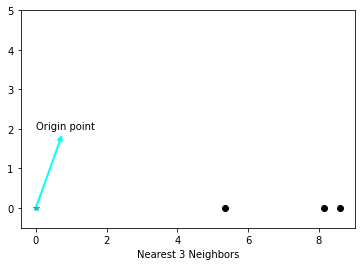

Distances to nearest neighbors:  [5.35723809 8.1375672  8.60581199]


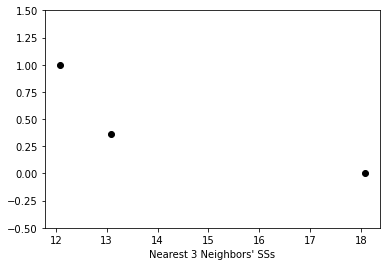

Similarity Scores:  [1.         0.36522219 0.00251824]


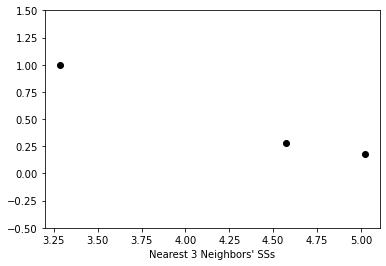

Similarity Scores:  [1.         0.27686573 0.17664295]


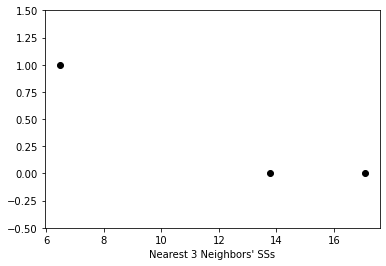

Similarity Scores:  [1.00000000e+00 6.73458881e-04 2.51672728e-05]


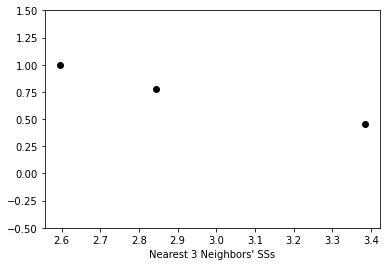

Similarity Scores:  [1.         0.7802495  0.45491992]


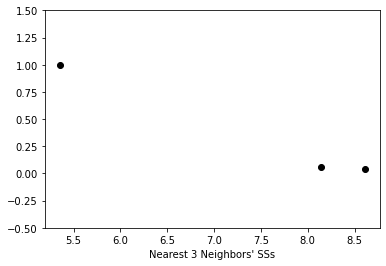

Similarity Scores:  [1.         0.06201809 0.03882954]
{'nns_indexes': array([143,  53, 100], dtype=int64), 'dists_to_nns': array([12.08511481, 13.09236419, 18.069311  ]), 'all_dists': array([   0.        ,   50.26778292,  500.19789084,  300.25009575,
        100.42235807,  125.00339995,  925.10638307,  550.00564543,
         51.05389309,  650.24227023,   50.23007067,  300.32690522,
        750.18101815,  425.03668077,  450.24931982,  350.07263532,
        150.00986634,   50.7394324 ,  200.04292039,   50.03338885,
         50.50227718,  200.01564939,  550.03508979,  600.0687044 ,
        200.00749986,  500.01315983,  150.0432271 ,  450.0555188 ,
        150.04092775,  425.24249552,  400.28835856,  200.20684304,
        200.02662323,  450.00289999,  900.0053611 ,  600.00687496,
        150.66180671,  650.0266533 ,  650.19304826,  750.0157665 ,
        850.04779866,  325.00783067,  300.1520448 ,  400.14558601,
        250.05249449,  550.04548903,  300.16403849,  300.61611733,
        850

In [278]:
test = my_UMAP(nearest_neighbors = 3)
test_dict = test.fit(int_cols, show_visuals=False)



# nneighbor = test_dict[1]
# for i in test_dict[0][1:]:
#     print(np.exp(-(i-nneighbor)))

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
sns.pairplot(penguins.drop("year", axis=1), hue='species');

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);